In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [2]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [3]:
df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [4]:
labels = df[1].values

In [5]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [6]:
texts = df[0].values.tolist()

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [9]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [10]:
X_train_tokenized

{'input_ids': array([[ 101, 2856, 2011, ..., 5525, 2928,  102],
       [ 101, 1037, 6171, ...,    0,    0,    0],
       [ 101, 2005, 2216, ..., 4566, 2003,  102],
       ...,
       [ 101, 2004, 2005, ...,    0,    0,    0],
       [ 101, 2009, 2089, ...,    0,    0,    0],
       [ 101, 1996, 2143, ...,    0,    0,    0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

In [11]:
type(X_train_tokenized)

transformers.tokenization_utils_base.BatchEncoding

In [12]:
# Load and compile our model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_bert_en"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True,
                     save_weights_only=True,
    )

In [15]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=5, batch_size=128, validation_split=0.1,
                   callbacks=[es, mc])

Epoch 1/5
39/39 [==============================] - 243s 6s/step - loss: 0.5450 - accuracy: 0.7768 - val_loss: 0.4183 - val_accuracy: 0.8448
Epoch 2/5
39/39 [==============================] - 227s 6s/step - loss: 0.3107 - accuracy: 0.8906 - val_loss: 0.3153 - val_accuracy: 0.8736
Epoch 3/5
39/39 [==============================] - 219s 6s/step - loss: 0.2107 - accuracy: 0.9279 - val_loss: 0.3324 - val_accuracy: 0.8664
Epoch 4/5
39/39 [==============================] - 220s 6s/step - loss: 0.1367 - accuracy: 0.9580 - val_loss: 0.3290 - val_accuracy: 0.8827
Epoch 5/5
39/39 [==============================] - 219s 6s/step - loss: 0.0905 - accuracy: 0.9745 - val_loss: 0.4095 - val_accuracy: 0.8827
Epoch 5: early stopping


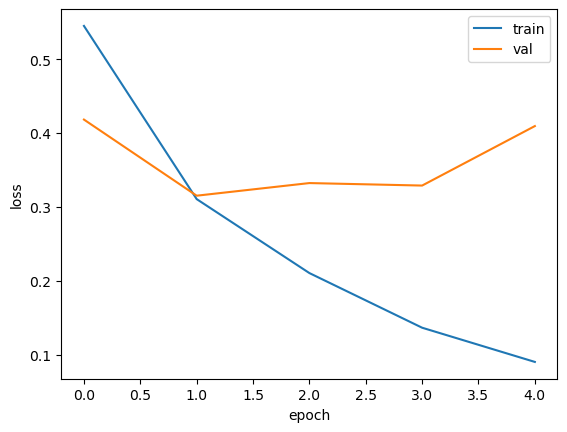

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [17]:
model.load_weights(checkpoint_filepath)
model.evaluate(dict(X_test_tokenized), y_test)

44/44 [==============================] - 19s 438ms/step - loss: 0.2927 - accuracy: 0.8931


[0.2926516830921173, 0.8930636048316956]

In [18]:
y_preds = model.predict(dict(X_test_tokenized))

44/44 [==============================] - 21s 441ms/step


In [19]:
len(y_preds)

1

In [20]:
len(y_preds.logits)

1384

In [21]:
y_preds

TFSequenceClassifierOutput(loss=None, logits=array([[ 2.0343177, -2.065621 ],
       [ 2.4051044, -2.3587146],
       [-3.2595303,  3.2617202],
       ...,
       [-3.2134976,  3.1901653],
       [-2.9203486,  2.9155831],
       [-2.661487 ,  2.5819414]], dtype=float32), hidden_states=None, attentions=None)

In [22]:
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()

In [23]:
prediction_probs

array([[0.9836965 , 0.01630349],
       [0.9915392 , 0.00846077],
       [0.00146966, 0.99853027],
       ...,
       [0.00165275, 0.9983473 ],
       [0.00291219, 0.9970878 ],
       [0.00525436, 0.9947456 ]], dtype=float32)

In [24]:
y_predictions = np.argmax(prediction_probs, axis=1)

In [25]:
y_predictions

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [26]:
y_test = np.argmax(y_test, axis=1)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       676
           1       0.88      0.92      0.90       708

    accuracy                           0.89      1384
   macro avg       0.89      0.89      0.89      1384
weighted avg       0.89      0.89      0.89      1384

